# MNIST with SciKit-Learn and skorch

In [ ]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## Loading Data

In [ ]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
mnist.data.shape

(70000, 784)

## Preprocessing Data


In [ ]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

In [ ]:
X /= 255.0

In [ ]:
X.min(), X.max()

(0.0, 1.0)

Note: data is not normalized.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [ ]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

In [ ]:
type(X_test)

numpy.ndarray

### Print a selection of training images and their labels

In [ ]:
def plot_example(X, y, n=5):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:n].reshape(n, 28, 28), y[:n])):
        plt.figure(figsize=(1.5 * n, 1.5 * n))
        plt.subplot(1, n, 1 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

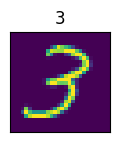

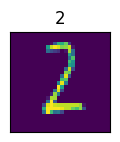

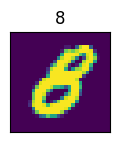

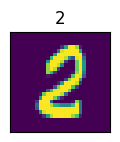

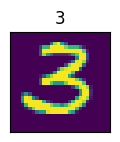

In [ ]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from skorch import NeuralNetClassifier

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x, eval=False):

        outputs = []
        x = x.reshape((x.shape[0], 1, 28, 28))

        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        outputs.append(x)
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        outputs.append(x)

        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)

        Ts = None
        layers = None
        layer_num = 0
        if eval:
          for X in outputs:
            X = X.reshape((X.shape[0], np.prod(X.shape) // X.shape[0]))
            Ts = torch.cat((Ts, X), 1) if Ts is not None else X
            l = torch.ones_like(X) * layer_num
            layers = torch.cat((layers, l), 1) if layers is not None else l
            layer_num += 1
          return x, Ts, layers

        return x


In [ ]:

torch.manual_seed(0)

module = Cnn()
cnn = NeuralNetClassifier(
    module,
    max_epochs=3,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [ ]:
adversaries_x = torch.tensor(X_test).to(device)
adversaries_y = torch.tensor(y_test).to(device)
epsilon = 10 / 255

In [ ]:
step = 500
for i in range(10):
  adversaries_x = adversaries_x.to(device)
  cnn.fit(adversaries_x, adversaries_y)
  loss = nn.CrossEntropyLoss()
  inp = adversaries_x
  inp.requires_grad = True
  for j in range(0, inp.shape[0], step):
    module.eval()
    out = cnn.module(inp[j:j + step])
    loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))
    loss_val.backward()
    delta = epsilon * torch.sign(inp.grad.detach()[j:j + step])
    if j == 0:
      adversaries_x = torch.clamp(inp.detach()[j:j + step] + delta, 0.0, 1)
    else:
      adversaries_x = torch.cat((adversaries_x.detach(), torch.clamp(inp.detach()[j:j + step] + delta, 0.0, 1)), 0)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8628       0.9380        0.2083  1.4417
      2        0.2858       0.9549        0.1361  0.5334
      3        0.2165       0.9649        0.1092  0.5444


<ipython-input-15-2bf0219f7bb3>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.2833       0.9549        0.1470  0.5366
      2        0.2299       0.9566        0.1356  0.5277
      3        0.1991       0.9614        0.1189  0.5385
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-15-2bf0219f7bb3>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.2908       0.9389        0.1792  0.5410
      2        0.2426       0.9497        0.1565  0.5335
      3        0.2168       0.9549        0.1415  0.5457
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-15-2bf0219f7bb3>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3125       0.9254        0.2154  0.5348
      2        0.2643       0.9351        0.1949  0.5271
      3        0.2420       0.9440        0.1712  0.5918
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-15-2bf0219f7bb3>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3599       0.9163        0.2568  0.6660
      2        0.3086       0.9277        0.2227  0.6915
      3        0.2771       0.9366        0.1972  0.6391
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-15-2bf0219f7bb3>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3874       0.9100        0.2849  0.5238
      2        0.3429       0.9220        0.2414  0.5264
      3        0.2600       0.9509        0.1476  0.5337
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-15-2bf0219f7bb3>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4677       0.9006        0.3091  0.5322
      2        0.3446       0.9131        0.2564  0.5288
      3        0.2661       0.9626        0.1192  0.5404
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-15-2bf0219f7bb3>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4746       0.9006        0.3079  0.5369
      2        0.3405       0.9346        0.1988  0.5259
      3        0.2370       0.9571        0.1244  0.5293
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-15-2bf0219f7bb3>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5361       0.9014        0.3049  0.5398
      2        0.3334       0.9397        0.1770  0.5286
      3        0.2462       0.9640        0.1146  0.5414
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-15-2bf0219f7bb3>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6137       0.8760        0.3773  0.5265
      2        0.4456       0.8997        0.3030  0.5281
      3        0.3714       0.9237        0.2309  0.5277


<ipython-input-15-2bf0219f7bb3>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


In [ ]:
attacked = adversaries_x.cpu().detach().numpy()

In [ ]:
mnist_dim = X.shape[1]
hidden_dims = [int(mnist_dim/8)]
output_dim = len(np.unique(mnist.target))

In [ ]:
mnist_dim, hidden_dims, output_dim

(784, [98], 10)

In [ ]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dims=hidden_dims,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden = nn.ModuleList()
        for i in range(len(hidden_dims)):
            if i == 0:
              self.hidden.append(nn.Linear(mnist_dim, hidden_dims[i]))
            else:
              self.hidden.append(nn.Linear(hidden_dims[i - 1], hidden_dims[i]))
        self.output = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, X, eval=False, **kwargs):
        Ts = None
        layers = None
        layer_num = 0
        for h in self.hidden:
          X = F.relu(h(X))
          if eval:
            Ts = torch.cat((Ts, X), 1) if Ts is not None else X
            l = torch.ones_like(X) * layer_num
            layers = torch.cat((layers, l), 1) if layers is not None else l
          layer_num += 1
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        if eval:
          return X, Ts, layers
        return X

In [ ]:

nets = []

In [ ]:
torch.manual_seed(0)

net1 = NeuralNetClassifier(
    ClassifierModule(mnist_dim, [100], output_dim),
    max_epochs=20,
    lr=0.1,
    device=device,
)

In [ ]:
net1.fit(X_train, y_train);
nets.append(net1)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8367       0.8905        0.3961  1.0053
      2        0.4284       0.9098        0.3098  0.9675
      3        0.3556       0.9241        0.2624  0.9734
      4        0.3177       0.9331        0.2324  1.2361
      5        0.2917       0.9386        0.2125  2.1038
      6        0.2702       0.9412        0.1987  1.3475
      7        0.2533       0.9436        0.1900  0.9565
      8        0.2380       0.9490        0.1747  0.9436
      9        0.2291       0.9503        0.1688  1.2739
     10        0.2202       0.9527        0.1576  2.0410
     11        0.2106       0.9535        0.1554  1.3911
     12        0.2033       0.9557        0.1476  1.5361
     13        0.1999       0.9578        0.1457  2.2510
     14        0.1932       0.9564        0.1451  1.2219
     15        0.1892       0.9600        0.1360  0.9498
     16        0.1848       0.9

In [ ]:
y_pred = net1.predict(X_test)
accuracy_score(y_test, y_pred)

0.9621142857142857

In [ ]:
y_pred = net1.predict(attacked)
accuracy_score(y_test, y_pred)

0.7373142857142857

In [ ]:
hidden_dims = [60, 40]
net2 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net2.fit(X_train, y_train);
nets.append(net2)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1661       0.8602        0.4798  1.0281
      2        0.5438       0.9013        0.3457  1.1051
      3        0.4252       0.9054        0.3066  1.4123
      4        0.3559       0.9241        0.2526  1.2854
      5        0.3058       0.9371        0.2097  1.0529
      6        0.2719       0.9398        0.1980  1.0766
      7        0.2455       0.9493        0.1669  1.0330
      8        0.2231       0.9549        0.1506  1.0437
      9        0.2050       0.9583        0.1409  1.0431
     10        0.1941       0.9487        0.1649  1.0375
     11        0.1786       0.9576        0.1411  1.0391
     12        0.1698       0.9594        0.1365  1.0984
     13        0.1616       0.9638        0.1233  1.0413
     14        0.1540       0.9667        0.1179  1.4343
     15        0.1490       0.9642        0.1253  1.4167
     16        0.1408       0.9

In [ ]:
y_pred = net2.predict(X_test)
accuracy_score(y_test, y_pred)

0.9658857142857142

In [ ]:
y_pred = net2.predict(attacked)
accuracy_score(y_test, y_pred)

0.6573714285714286

In [ ]:
hidden_dims = [40, 60]
net3 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net3.fit(X_train, y_train);
nets.append(net3)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0644       0.8392        0.5411  2.2464
      2        0.4887       0.8910        0.3638  1.1920
      3        0.3958       0.9106        0.3017  1.0366
      4        0.3449       0.9265        0.2449  1.0222
      5        0.3060       0.9277        0.2361  1.0341
      6        0.2778       0.9265        0.2384  1.0161
      7        0.2458       0.9399        0.2005  1.0037
      8        0.2315       0.9448        0.1818  1.1188
      9        0.2161       0.8960        0.3826  1.6231
     10        0.2010       0.9453        0.1768  1.8061
     11        0.1853       0.9530        0.1528  1.4770
     12        0.1729       0.9475        0.1708  1.7657
     13        0.1687       0.9543        0.1540  1.7852
     14        0.1607       0.9521        0.1560  1.0274
     15        0.1530       0.9604        0.1341  1.0219
     16        0.1458       0.9

In [ ]:
y_pred = net3.predict(X_test)
accuracy_score(y_test, y_pred)

0.9597142857142857

In [ ]:
y_pred = net3.predict(attacked)
accuracy_score(y_test, y_pred)

0.6939428571428572

In [ ]:
hidden_dims = [50, 50]
net4 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net4.fit(X_train, y_train);
nets.append(net4)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1053       0.8670        0.4649  1.4118
      2        0.5137       0.8955        0.3592  1.0144
      3        0.4177       0.9158        0.2846  1.0100
      4        0.3572       0.9280        0.2449  1.0180
      5        0.3134       0.9356        0.2203  1.0454
      6        0.2782       0.9252        0.2445  1.0226
      7        0.2539       0.9443        0.1855  1.0391
      8        0.2333       0.9474        0.1707  1.0292
      9        0.2143       0.9535        0.1540  1.0246
     10        0.2040       0.9542        0.1500  1.0375
     11        0.1884       0.9538        0.1533  1.2939
     12        0.1807       0.9588        0.1380  1.4376
     13        0.1697       0.9599        0.1342  1.0939
     14        0.1590       0.9630        0.1288  1.0253
     15        0.1521       0.9605        0.1318  1.0527
     16        0.1490       0.9

In [ ]:
y_pred = net4.predict(X_test)
accuracy_score(y_test, y_pred)

0.9608

In [ ]:
y_pred = net4.predict(attacked)
accuracy_score(y_test, y_pred)

0.6742857142857143

In [ ]:
hidden_dims = [20, 20, 20, 20, 20]
net5 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net5.fit(X_train, y_train);
nets.append(net5)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2984       0.1269        2.2744  1.2011
      2        1.9774       0.4371        1.5347  1.6510
      3        1.4230       0.6090        1.2919  1.4671
      4        1.1137       0.6813        0.8876  1.1820
      5        0.9511       0.7329        0.7207  1.1914
      6        0.8387       0.7796        0.7745  1.1933
      7        0.7905       0.8744        0.5672  1.1824
      8        0.7495       0.8911        0.4979  1.1848
      9        0.7063       0.9079        0.4706  1.1697
     10        0.6857       0.9037        0.4678  1.1772
     11        0.6515       0.9044        0.4658  1.3045
     12        0.6297       0.9102        0.4281  1.6441
     13        0.6082       0.9178        0.4372  1.4249
     14        0.5867       0.9104        0.4714  1.2070
     15        0.5731       0.9148        0.4238  1.1816
     16        0.5613       0.9

In [ ]:
y_pred = net5.predict(X_test)
accuracy_score(y_test, y_pred)

0.9292571428571429

In [ ]:
y_pred = net5.predict(attacked)
accuracy_score(y_test, y_pred)

0.5347428571428572

# Convolutional Network


In [ ]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn(),
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
    batch_size=64,
)

In [ ]:
cnn.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3949       0.9749        0.0793  2.7920
      2        0.1652       0.9794        0.0655  2.3029
      3        0.1388       0.9818        0.0543  2.2968
      4        0.1228       0.9843        0.0473  2.3061
      5        0.1125       0.9855        0.0461  2.3412
      6        0.1052       0.9851        0.0455  2.7756
      7        0.1007       0.9868        0.0402  2.7181
      8        0.0929       0.9874        0.0392  2.2819
      9        0.0934       0.9874        0.0403  2.3102
     10        0.0795       0.9879        0.0377  2.4254


In [ ]:
y_pred = cnn.predict(X_test)
accuracy_score(y_test, y_pred)

0.9892571428571428

In [ ]:
y_pred = cnn.predict(attacked)
accuracy_score(y_test, y_pred)

0.7082857142857143

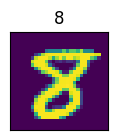

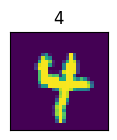

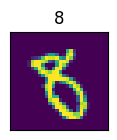

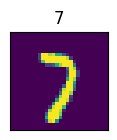

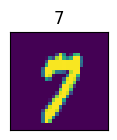

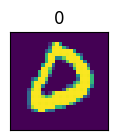

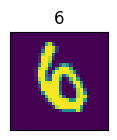

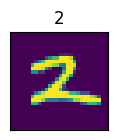

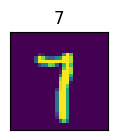

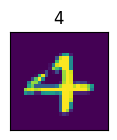

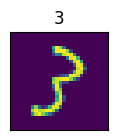

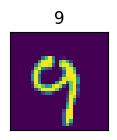

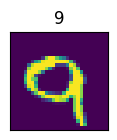

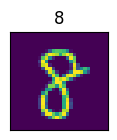

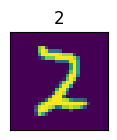

In [ ]:
plot_example(X_test, y_test, n=15)

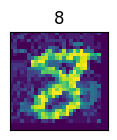

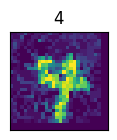

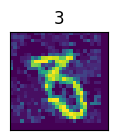

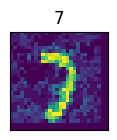

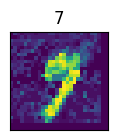

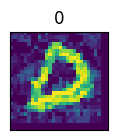

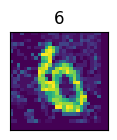

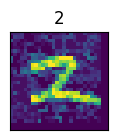

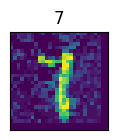

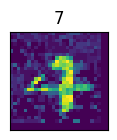

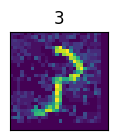

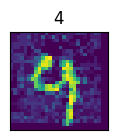

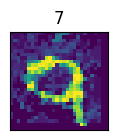

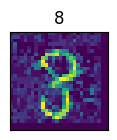

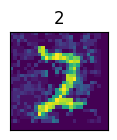

In [ ]:
plot_example(attacked, y_pred, n=15)